# Rice leaf disease prediction

| Step               | Description                  |
| ------------------ | ---------------------------- |
| 1. Data Collection | Get labeled images           |
| 2. Preprocessing   | Resize, normalize, split     |
| 3. Build CNN       | Define the architecture      |
| 4. Compile         | Set optimizer, loss, metrics |
| 5. Train           | Fit on training data         |
| 6. Evaluate        | Accuracy, confusion matrix   |
| 7. Tune            | Improve performance          |
| 8. Save            | Save model to disk           |
| 9. Predict         | Test on new data             |
| 10. Deploy         | Optional app or API          |


# Problem Statement

Task 1:-Prepare a complete data analysis report on the given data.

Task 2:-Create a model which can classify the three major attacking diseases of rice plants like leaf blast, bacterial blight and brown spot.

Task3:- Analyze various techniques like Data Augmentation, etc and create a report on that.


# Importing necessary libraries

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Loading Dataset

In [2]:

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
#set path for dataset
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
data_path = "/content/drive/MyDrive/Rice_leaf"

# Data Augumentation

In [5]:
#create image generator
datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.3) #normalize and split

# Data Augmentation
aug_datagen =ImageDataGenerator(
    rotation_range=10,         # Rotate image up to 10 degrees
    width_shift_range=0.05,     # Shift image horizontally by 5%
    height_shift_range=0.05,    # Shift image vertically by 5%
    zoom_range=0.1,            # Random zoom in/out by 10%
    horizontal_flip=True,      # Randomly flip image horizontally
    rescale=1./255,            # Also normalize
    validation_split=0.3      # Same split as before
)

In [6]:
train_img = aug_datagen.flow_from_directory(data_path,
                                           target_size = (128,128),#Each image is reshaped into given size.
                                           batch_size = 32,#Each batch contains 32 images
                                           color_mode="rgb",# Image will load as color
                                           class_mode = 'categorical',#Label encoder (oneHot) for multi class classification
                                           subset = 'training') # Training split
val_img = datagen.flow_from_directory(data_path,
                                           target_size = (128,128),
                                           batch_size = 32,
                                           color_mode="rgb",
                                           class_mode = 'categorical',
                                           subset = 'validation', # Validation Split
                                           shuffle=False,         # For stable evaluation
                                           seed=42)


Found 84 images belonging to 3 classes.
Found 35 images belonging to 3 classes.


# Exploratory Data Analysis

In [7]:
print('Total Training image :',train_img.samples)
print('Total validation image :',val_img.samples)

Total Training image : 84
Total validation image : 35


In [8]:
print('Target classes :',train_img.class_indices)

Target classes : {'Bacterial leaf blight': 0, 'Brown spot': 1, 'Leaf smut': 2}


In [9]:
train_img.image_shape

(128, 128, 3)

In [10]:
train_img.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

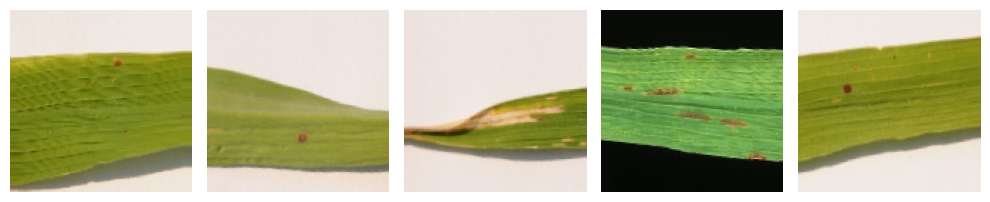

In [11]:
#For visualizing the augumented images
# Get a batch of augmented images
images, labels = next(train_img)

# Display first 5 images
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [12]:
#Get class names and counts
class_names = os.listdir(data_path)
class_counts = {cls: len(os.listdir(os.path.join(data_path, cls))) for cls in class_names}
print(class_names)
print(class_counts)

['Brown spot', 'Leaf smut', 'Bacterial leaf blight']
{'Brown spot': 40, 'Leaf smut': 39, 'Bacterial leaf blight': 40}


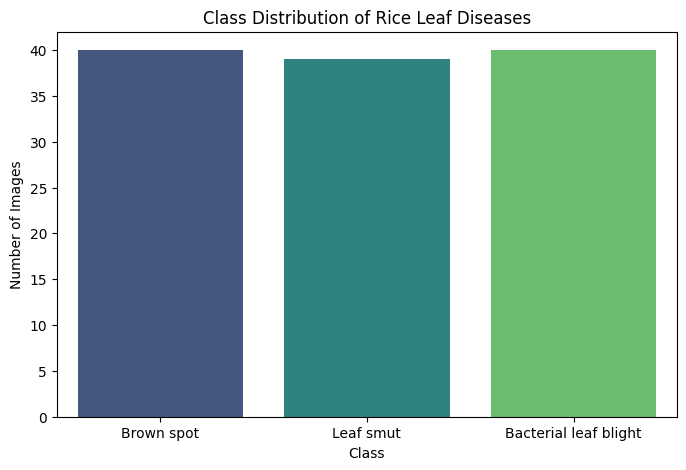

In [13]:
# Plot class distribution
plt.figure(figsize=(8,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
plt.title("Class Distribution of Rice Leaf Diseases")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

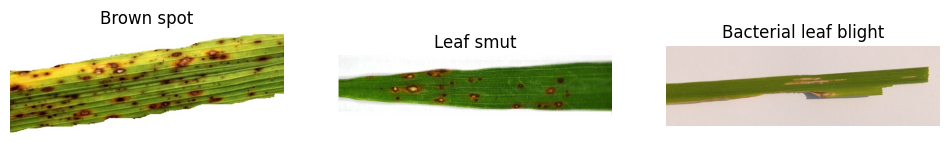

In [14]:
#some random sample images from each class
plt.figure(figsize=(12, 8))
for i, cls in enumerate(class_names):
    folder = os.path.join(data_path, cls)
    img_file = random.choice(os.listdir(folder))
    img = Image.open(os.path.join(folder, img_file))

    plt.subplot(1, len(class_names), i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")
plt.show()

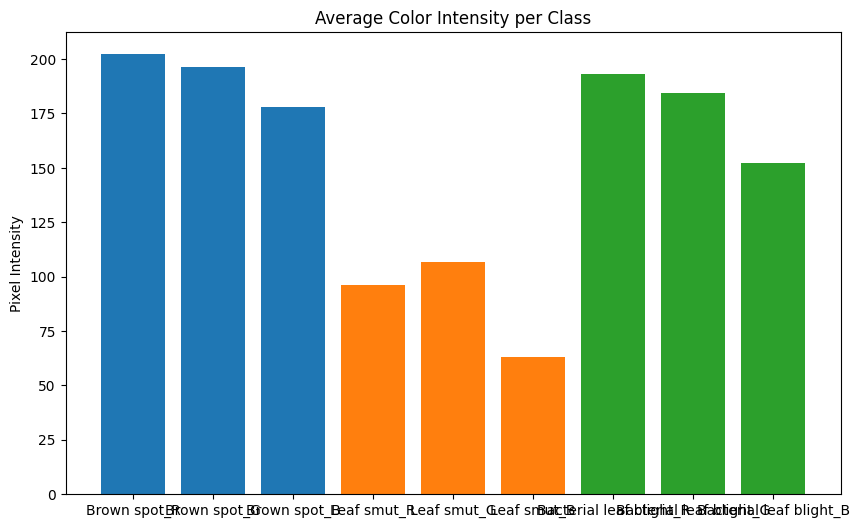

In [16]:
#Average pixel intensity per class (color distribution check)
plt.figure(figsize=(10, 6))
for cls in class_names:
    folder = os.path.join(data_path, cls)
    img_file = random.choice(os.listdir(folder))
    img = Image.open(os.path.join(folder, img_file)).convert("RGB")
    img_array = np.array(img)

    avg_rgb = img_array.mean(axis=(0,1))  # average RGB
    plt.bar([cls + "_R", cls + "_G", cls + "_B"], avg_rgb)

plt.title("Average Color Intensity per Class")
plt.ylabel("Pixel Intensity")
plt.show()


# Building CNN

In [81]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
import tensorflow as tf
# Creating seed to get same accuracy
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu',
                 input_shape=(128, 128, 3)))#padding = same --> 1 layer of pixel info is added , padding = valid ---> nothing is added
#16 filters with 2X2 kernel with padding size same as input and output
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))# 40% nurons are deactivated to avoid overfitting
model.add(Flatten())# Coverting data into 1D array
model.add(Dense(500, activation='relu'))#500 nurons with relu AF
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.3))#regularization --> deactivates inorder to avoid overfitting
#It has to btw input and hidden layer or hidden and output layer
model.add(Dense(3, activation='softmax'))

model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 500)            │     8,192,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,280,599 (31.59 MB)

 Trainable params: 8,280,599 (31.59 MB)

 Non-trainable params: 0 (0.00 B)

#Transfer Learning

In [82]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Creating seed to get same accuracy
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

base_model = MobileNetV2(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
base_model.trainable = False  # Freeze the convolutional base
# for layer in base_model.layers[-5:]:
#     layer.trainable = True

tf_model = Sequential([
    base_model,
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(60,activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

tf_model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 4, 4, 1280)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │     2,621,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 60)             │         7,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 3)              │           183 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,887,475 (18.64 MB)

 Trainable params: 2,629,491 (10.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Compile the model
 - Setting loss,optimizer,metrics

In [83]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
loss = CategoricalCrossentropy(label_smoothing=0.05)
model.compile(loss = loss, optimizer=Adam(learning_rate=1e-3),metrics = ['accuracy'])

In [85]:
loss = CategoricalCrossentropy(label_smoothing=0.05)
tf_model.compile(loss = loss, optimizer=Adam(learning_rate=1e-3),metrics = ['accuracy'])

# Train the model

In [86]:
hist= model.fit(train_img,batch_size = 20,epochs = 30,validation_data = (val_img),shuffle=False)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3069 - loss: 1.3294 - val_accuracy: 0.3429 - val_loss: 1.1419
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 674ms/step - accuracy: 0.3131 - loss: 1.1368 - val_accuracy: 0.3143 - val_loss: 1.1149
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 826ms/step - accuracy: 0.2779 - loss: 1.1127 - val_accuracy: 0.3429 - val_loss: 1.1015
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 779ms/step - accuracy: 0.3644 - loss: 1.0930 - val_accuracy: 0.3714 - val_loss: 1.1038
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 634ms/step - accuracy: 0.4113 - loss: 1.0857 - val_accuracy: 0.3143 - val_loss: 1.1045
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 617ms/step - accuracy: 0.3761 - loss: 1.0870 - val_accuracy: 0.3429 - val_loss: 1.0951
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 639ms/step - accuracy: 0.4550 - loss: 1.0574 - val_accuracy: 0.2571 - val_loss: 1.1771
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 639ms/step - accuracy: 0.5058 - loss: 1.0166 - val_accuracy: 0.4286 - val_loss: 1

In [87]:
hist_tf = tf_model.fit(train_img,batch_size = 20,epochs = 30,validation_data = (val_img),shuffle= False)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - accuracy: 0.3702 - loss: 2.6323 - val_accuracy: 0.4571 - val_loss: 1.4098
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 662ms/step - accuracy: 0.5298 - loss: 2.2848 - val_accuracy: 0.7143 - val_loss: 0.9505
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 634ms/step - accuracy: 0.5590 - loss: 1.6825 - val_accuracy: 0.6857 - val_loss: 0.8557
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 636ms/step - accuracy: 0.7638 - loss: 1.0411 - val_accuracy: 0.6857 - val_loss: 0.6393
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 631ms/step - accuracy: 0.7640 - loss: 0.7758 - val_accuracy: 0.8000 - val_loss: 0.6255
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 873ms/step - accuracy: 0.8601 - loss: 0.5702 - val_accuracy: 0.8571 - val_loss: 0.6282
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 689ms/step - accuracy: 0.8131 - loss: 0.6339 - val_accuracy: 0.8571 - val_loss: 0.6247
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 657ms/step - accuracy: 0.8445 - loss: 0.5483 - val_accuracy: 0.7429 - val_loss: 0

# Model Evaluation

In [88]:
print("Accuracy of Manual CNN model on training data : ", model.evaluate(train_img)[1]*100,"%")
print("Accuracy of Manual CNN model on validation data : " , model.evaluate(val_img)[1]*100 , "%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 578ms/step - accuracy: 0.7932 - loss: 0.5553
Accuracy of Manual CNN model on training data :  77.3809552192688 %
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7348 - loss: 0.8375
Accuracy of Manual CNN model on validation data :  74.28571581840515 %


In [90]:
print("Accuracy of Transfer Learning model on training data : ", tf_model.evaluate(train_img)[1]*100,"%")
print("Accuracy of Transfer Learning model on validation data : " , tf_model.evaluate(val_img)[1]*100 , "%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step - accuracy: 1.0000 - loss: 0.2079
Accuracy of Transfer Learning model on training data :  100.0 %
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8821 - loss: 0.6572 
Accuracy of Transfer Learning model on validation data :  88.57142925262451 %



# Analyzing the accuracy and loss for each epochs

Manual CNN:



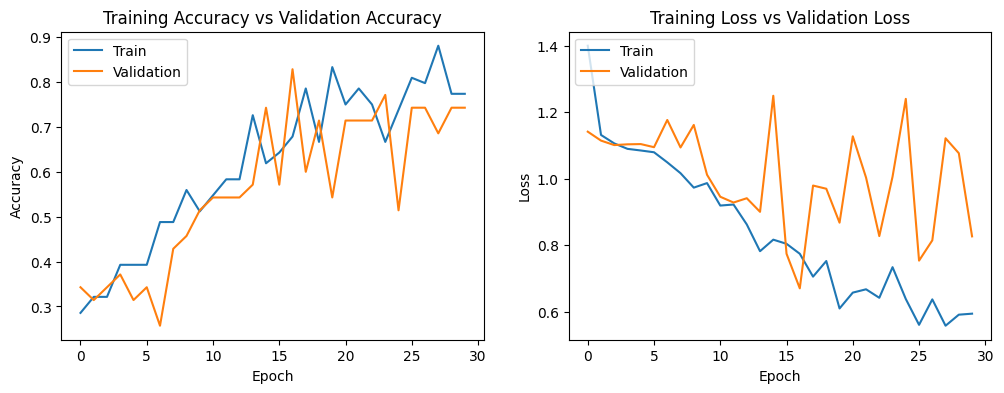

In [91]:

fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(hist.history['accuracy'])
ax[0].plot(hist.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(hist.history['loss'])
ax[1].plot(hist.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

print('Manual CNN:\n')
plt.show()

Transfer Learning :



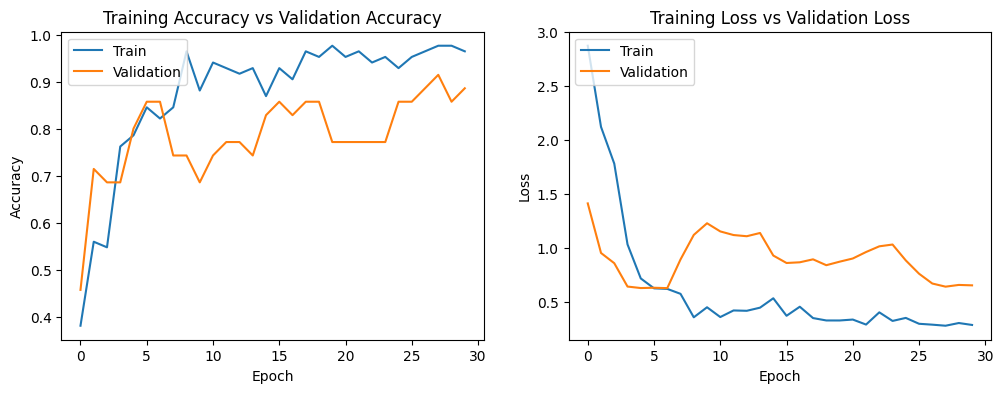

In [92]:
fig , ax = plt.subplots(1,2)
train_acc = hist_tf.history['accuracy']
train_loss = hist_tf.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(hist_tf.history['accuracy'])
ax[0].plot(hist_tf.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(hist_tf.history['loss'])
ax[1].plot(hist_tf.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')
print("Transfer Learning :\n")

plt.show()

In [94]:
# Train Test split
def extract_data(generator):
    data_list = []
    labels_list = []
    for _ in range(generator.__len__()):
        data, labels = next(generator)
        data_list.append(data)
        labels_list.append(labels)
    x = np.vstack(data_list)
    y = np.vstack(labels_list)
    return x, y

x_train, y_train = extract_data(train_img)
x_test, y_test = extract_data(val_img)

In [95]:
# Predicted values for Manual CNN
preds = model.predict(x_test)
y_pred_manualcnn = np.argmax(preds , axis = 1 )


# Predicted values for Transfer Learning
preds = tf_model.predict(x_test)
y_pred_tf = np.argmax(preds , axis = 1 )

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step


In [96]:
y_true = np.argmax(y_test, axis=1)

In [97]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred_manualcnn)
print('Manual CNN\n')
print(report)

report = classification_report(y_true,y_pred_tf)
print('Transfer Learning (MobileNetV2)\n')
print(report)

Manual CNN

              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.67      0.50      0.57        12
           2       0.69      0.82      0.75        11

    accuracy                           0.74        35
   macro avg       0.74      0.74      0.73        35
weighted avg       0.74      0.74      0.73        35

Transfer Learning (MobileNetV2)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.90      0.75      0.82        12
           2       0.77      0.91      0.83        11

    accuracy                           0.89        35
   macro avg       0.89      0.89      0.88        35
weighted avg       0.89      0.89      0.89        35



# Visualizing Actual vs Predicted lables

- predicted values(actual values)

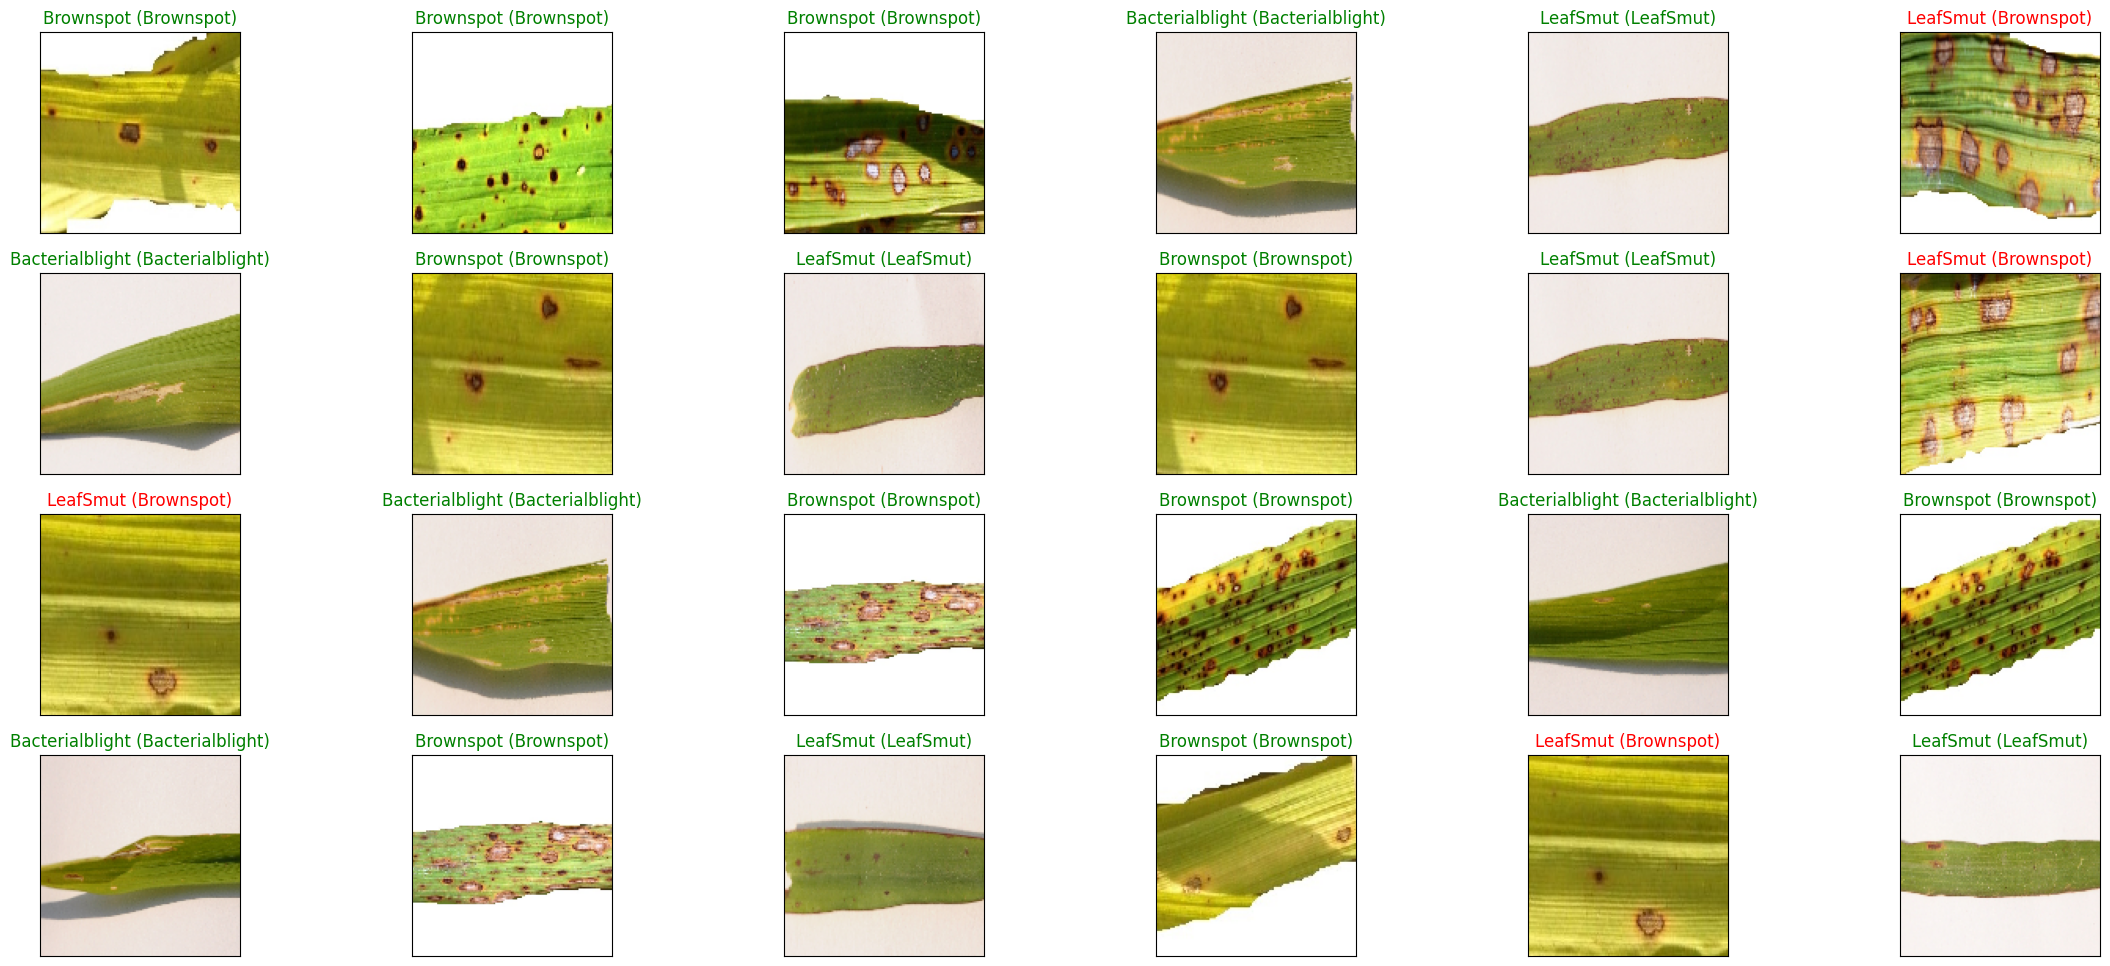

In [98]:
label_dict = {0 : 'Bacterialblight', 1 : 'Brownspot', 2 : 'LeafSmut'}

figure = plt.figure(figsize=(28, 12))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = label_dict[(y_pred_tf[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]

    ax.set_title("{} ({})".format((predict_index),
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

# Model Comparison Report

**Comparative Analysis :**

| Metric              | Manual CNN | MobileNetV2            |
| ------------------- | ---------- | ---------------------- |
| Training Accuracy   | 77.38%     | **100%**               |
| Validation Accuracy | 74.29%     | **88.57%**             |
| Macro F1-Score      | 0.73       | **0.88**               |
| Weak Class          | Class 1    | Class 1 (but improved) |


- MobileNetV2 significantly outperforms Manual CNN in terms of validation accuracy (+14.3%) and macro F1-score (+0.15).

- Manual CNN shows underfitting (low capacity to learn complex features).

- MobileNetV2 shows slight overfitting, but still maintains much higher validation accuracy.

**RESULTS :**

**Recommended Model: Transfer Learning (MobileNetV2)**

- Best validation accuracy (88.57%).

- Stronger generalization across classes.

- Robust performance on minority classes compared to Manual CNN.

- Efficient and lightweight, making it suitable for real-world deployment on mobile/edge devices.

# Report on Challenges Faced

**1. Small Dataset**

**Challenge:**

- Limited dataset size made it difficult for models to learn complex and generalized patterns.

- Risk of overfitting, as seen in MobileNetV2 (100% training accuracy but lower validation accuracy).

**Mitigation:**

- Applied data augmentation (rotation, zoom, shift, flip) to artificially expand dataset size and diversity.

- Used transfer learning (MobileNetV2 pre-trained on ImageNet) to leverage knowledge from large-scale datasets.

**2. Difficulty in Designing CNN Architecture**

**Challenge:**

- Finding the right combination of convolutional layers, dense units, and dropout for the Manual CNN model was difficult.

- Simpler models underfit, while complex ones tended to overfit.
Hyperparameter tuning required multiple iterations and trial-and-error.

**Mitigation:**

- Used transfer learning (MobileNetV2) to avoid manual design of complex architectures.

- Applied regularization techniques such as Dropout to control overfitting.

- Performed incremental tuning of dense layers and learning rate schedules.
